### Import function

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
def read_ans(filename):
    # Read the content of the answer text file and store it as a list of lines
    with open(filename, 'r') as file:
        answer_lines = file.readlines()
    a = np.zeros((len(answer_lines), 4))
    for i, line in enumerate(answer_lines):
        a[i, :] = [int(char) for char in line.strip()]  # Convert each character to an integer
    da = np.diff(a)
    da[da > 1] = 1
    da[da < 1] = -1
    return a, da

def score(filename, a, da):
    # Read the content of the answer text file and store it as a list of lines
    with open(filename, 'r') as file:
        response = file.readlines()
    r = np.zeros((len(response), 4))
    for i, line in enumerate(response):
        # Split the line by tab characters and convert each part to an integer
        r[i, :] = [int(value) for value in line.strip().split('\t') if value]
    dr = np.diff(r)
    dr[dr > 1] = 1
    dr[dr < 1] = -1
    r_ex = np.sum(a == r, axis=1)
    r_chg = np.sum(da == dr, axis=1)

    # Initialize counters for each number (1, 2, 3, 4) in each test
    count_correct = np.zeros((3, 4))  # 3 tests, 4 numbers

    # Update counters
    for test_idx in range(3):
        start_idx = sum([17, 20, 20][:test_idx])
        end_idx = start_idx + [17, 20, 20][test_idx]
        for row_idx in range(start_idx, end_idx):
            for num in range(1, 5):
                if num in r[row_idx] and num in a[row_idx] and r[row_idx, np.where(a[row_idx] == num)] == num:
                    count_correct[test_idx, num - 1] += 1

    return r_ex, r_chg, count_correct

def summary(r_ex, r_chg, count_correct):
    output = np.zeros(20)
    output[0] = np.sum(r_ex[0:17])
    output[1] = np.sum(r_ex[17:37])
    output[2] = np.sum(r_ex[37:57])
    output[4] = np.sum(r_chg[0:17])
    output[5] = np.sum(r_chg[17:37])
    output[6] = np.sum(r_chg[37:57])
    output[3] = np.sum(r_ex)
    output[7] = np.sum(r_chg)

    # Flatten count_correct to be added to the output array
    flat_counts = count_correct.flatten()
    output[8:20] = flat_counts

    return output

def summary_porcentage(df):
    df['eAir'] = (df['eAir'] / 68) * 100
    df['eVib'] = (df['eVib'] / 80) * 100
    df['eCar'] = (df['eCar'] / 80) * 100
    df['eAll'] = (df['eAll'] / 228) * 100
    df['dAir'] = (df['dAir'] / 51) * 100
    df['dVib'] = (df['dVib'] / 60) * 100
    df['dCar'] = (df['dCar'] / 60) * 100
    df['dAll'] = (df['dAll'] / 171) * 100
    return df

### Read answers

In [2]:
answers, answers_diffs = read_ans("/mnt/d/sharegit/MasterThesis_data/NeurosenseDB/PerceivedResponseAnswersheet.txt")

In [3]:
output = []
total_correct_counts = np.zeros((3, 4))  # To store total correct counts for each test and number
for folder_sub in range(1, 35):
    r_ex, r_chg, count_correct = score(f"/mnt/d/sharegit/MasterThesis_data/NeurosenseDB/sub-{folder_sub:02d}/other/sub-{folder_sub:02d}_R.tsv", answers, answers_diffs)
    folder_sub_output = [folder_sub]
    folder_sub_output.extend(summary(r_ex, r_chg, count_correct).tolist())  # Use extend to append values to the list
    output.append(folder_sub_output)
    total_correct_counts += count_correct

df_scores = pd.DataFrame(output, columns=["ID", "eAir", "eVib", "eCar", "eAll", "dAir", "dVib", "dCar", "dAll", 
                                          "a1", "a2", "a3", "a4", "v1", "v2", "v3", "v4", "c1", "c2", "c3", "c4"])
df_scores = df_scores[(df_scores != 0).all(axis=1)]
df_scores.reset_index(drop=True, inplace=True)
df_scores = summary_porcentage(df_scores)
df_scores = df_scores.set_index(list(df_scores)[0])

df_scores['a1'] = df_scores['a1'].div(17).mul(100)
df_scores['a2'] = df_scores['a2'].div(17).mul(100)
df_scores['a3'] = df_scores['a3'].div(17).mul(100)
df_scores['a4'] = df_scores['a4'].div(17).mul(100)

df_scores['v1'] = df_scores['v1'].div(20).mul(100)
df_scores['v2'] = df_scores['v2'].div(20).mul(100)
df_scores['v3'] = df_scores['v3'].div(20).mul(100)
df_scores['v4'] = df_scores['v4'].div(20).mul(100)

df_scores['c1'] = df_scores['c1'].div(20).mul(100)
df_scores['c2'] = df_scores['c2'].div(20).mul(100)
df_scores['c3'] = df_scores['c3'].div(20).mul(100)
df_scores['c4'] = df_scores['c4'].div(20).mul(100)

### Standarize data

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_clust_scaled = scaler.fit_transform(df_scores)

### Print the number of corrects per intensity

In [5]:
# Print out the counts of correct answers for each number and test
for test_idx, test_name in enumerate(['Air', 'Vib', 'Car']):
    print(f"Test {test_name}:")
    for num in range(1, 5):
        print(f"  Number {num} correct: {total_correct_counts[test_idx, num - 1]}")

Test Air:
  Number 1 correct: 377.0
  Number 2 correct: 335.0
  Number 3 correct: 382.0
  Number 4 correct: 476.0
Test Vib:
  Number 1 correct: 568.0
  Number 2 correct: 572.0
  Number 3 correct: 609.0
  Number 4 correct: 626.0
Test Car:
  Number 1 correct: 427.0
  Number 2 correct: 349.0
  Number 3 correct: 417.0
  Number 4 correct: 549.0


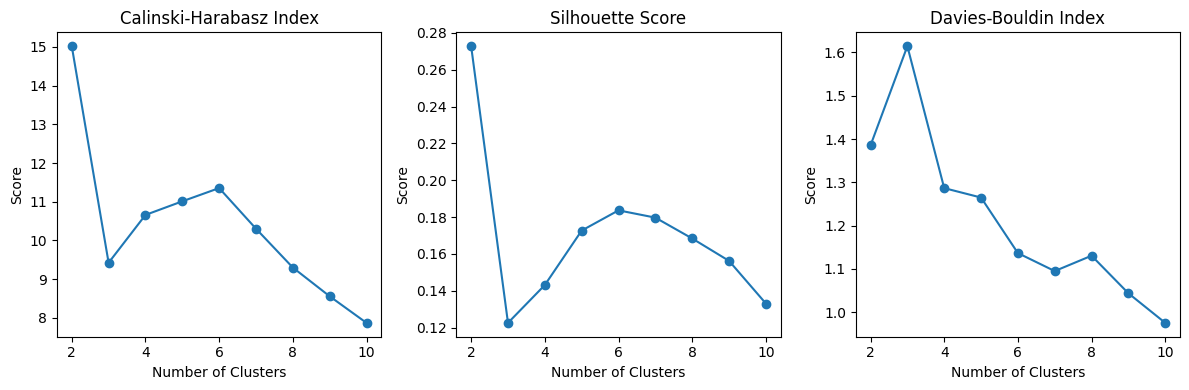

In [6]:
cluster_range = range(2, 11)

calinski_harabasz_scores = []
silhouette_scores = []
davies_bouldin_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_clust_scaled)
    
    calinski_harabasz_scores.append(calinski_harabasz_score(df_clust_scaled, cluster_labels))
    silhouette_scores.append(silhouette_score(df_clust_scaled, cluster_labels))
    davies_bouldin_scores.append(davies_bouldin_score(df_clust_scaled, cluster_labels))

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(cluster_range, calinski_harabasz_scores, marker='o')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.subplot(1, 3, 2)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.subplot(1, 3, 3)
plt.plot(cluster_range, davies_bouldin_scores, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

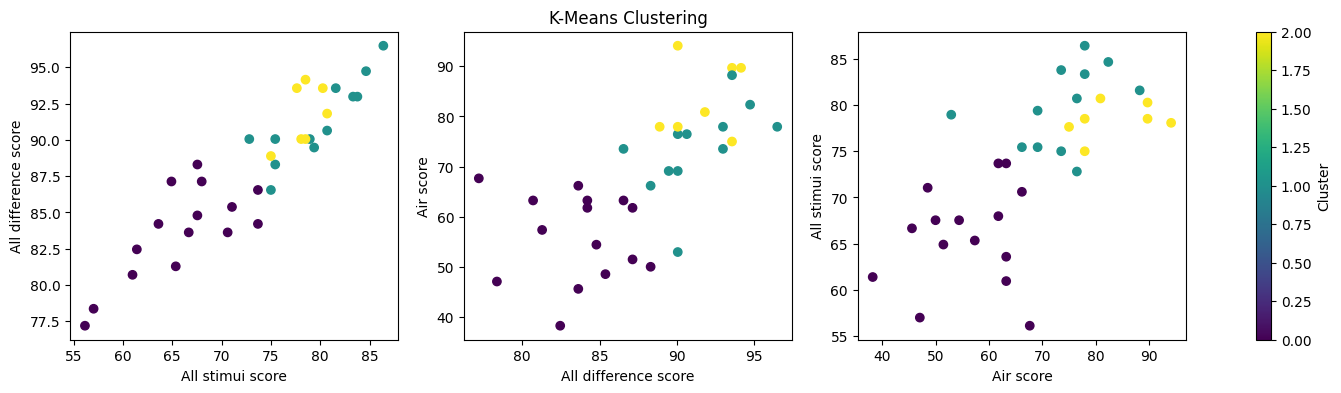

In [7]:
# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust the number of clusters as needed
kmeans.fit(df_clust_scaled)

# Add cluster labels to the DataFrame
df_scores['Cluster'] = kmeans.labels_

# Create a mapping of the current cluster labels to the new labels
cluster_mapping = {0: 0, 1: 3, 2: 1}  # Adjust based on your specific requirements

# Apply the mapping to the 'Cluster' column
df_scores['Cluster'] = df_scores['Cluster'].map(cluster_mapping)

# If you need to swap cluster labels 1 and 2 after the initial renaming
df_scores['Cluster'] = df_scores['Cluster'].replace({3: 2})

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Plot for eAll vs dAll
scatter1 = axes[0].scatter(df_scores['eAll'], df_scores['dAll'], c=df_scores['Cluster'], cmap='viridis')
axes[0].set_xlabel('All stimui score')
axes[0].set_ylabel('All difference score')

# Plot for dAll vs eAir
scatter2 = axes[1].scatter(df_scores['dAll'], df_scores['eAir'], c=df_scores['Cluster'], cmap='viridis')
axes[1].set_xlabel('All difference score')
axes[1].set_ylabel('Air score')
axes[1].set_title('K-Means Clustering')

# Plot for eAir vs eAll
scatter3 = axes[2].scatter(df_scores['eAir'], df_scores['eAll'], c=df_scores['Cluster'], cmap='viridis')
axes[2].set_xlabel('Air score')
axes[2].set_ylabel('All stimui score')

# Add a color bar to indicate clusters
cbar = fig.colorbar(scatter3, ax=axes.ravel().tolist(), label='Cluster')
plt.show()

### Estimate the feature importance by using Random Forest Feature Importance 

In [8]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Prepare the data
y = df_scores['Cluster']
X = df_scores.drop(columns=['Cluster'])

# Fit Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

   Feature  Importance
3     eAll    0.164403
0     eAir    0.130372
7     dAll    0.125009
17      c2    0.083698
4     dAir    0.070985
9       a2    0.066293
8       a1    0.064514
2     eCar    0.062630
16      c1    0.056906
10      a3    0.041526
14      v3    0.019694
1     eVib    0.016885
6     dCar    0.016558
11      a4    0.015942
12      v1    0.013529
5     dVib    0.013507
15      v4    0.009959
19      c4    0.009686
13      v2    0.009236
18      c3    0.008666


### Select the most important features > 0.1

In [9]:
df_scores_filt = df_scores[["eAll", "eAir", "dAll"]]
df_clust = df_scores_filt.copy()

In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
df_clust_scaled = scaler.fit_transform(df_clust)

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # You can change the number of clusters
kmeans.fit(df_clust_scaled)
df_scores['Cluster_3'] = kmeans.labels_

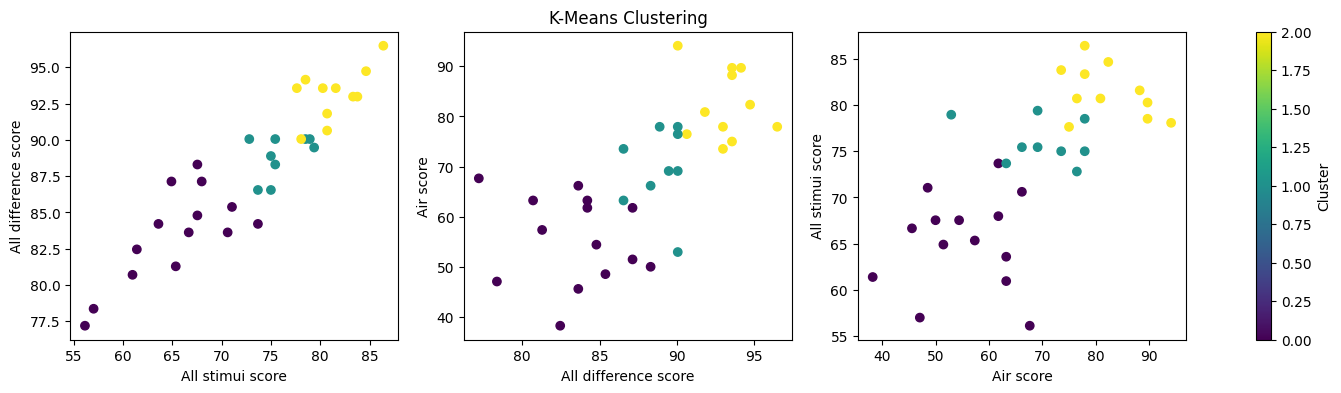

In [11]:
# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust the number of clusters as needed
kmeans.fit(df_clust_scaled)

# Add cluster labels to the DataFrame
df_scores['Cluster_3']= kmeans.labels_

# Create a mapping of the current cluster labels to the new labels
cluster_mapping = {0: 0, 1: 3, 2: 1}  # Adjust based on your specific requirements

# Apply the mapping to the 'Cluster' column
df_scores['Cluster_3'] = df_scores['Cluster_3'].map(cluster_mapping)

# If you need to swap cluster labels 1 and 2 after the initial renaming
df_scores['Cluster_3'] = df_scores['Cluster_3'].replace({3: 2})

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Plot for eAll vs dAll
scatter1 = axes[0].scatter(df_scores['eAll'], df_scores['dAll'], c=df_scores['Cluster_3'], cmap='viridis')
axes[0].set_xlabel('All stimui score')
axes[0].set_ylabel('All difference score')

# Plot for dAll vs eAir
scatter2 = axes[1].scatter(df_scores['dAll'], df_scores['eAir'], c=df_scores['Cluster_3'], cmap='viridis')
axes[1].set_xlabel('All difference score')
axes[1].set_ylabel('Air score')
axes[1].set_title('K-Means Clustering')

# Plot for eAir vs eAll
scatter3 = axes[2].scatter(df_scores['eAir'], df_scores['eAll'], c=df_scores['Cluster_3'], cmap='viridis')
axes[2].set_xlabel('Air score')
axes[2].set_ylabel('All stimui score')

# Add a color bar to indicate clusters
cbar = fig.colorbar(scatter3, ax=axes.ravel().tolist(), label='Cluster')
plt.show()

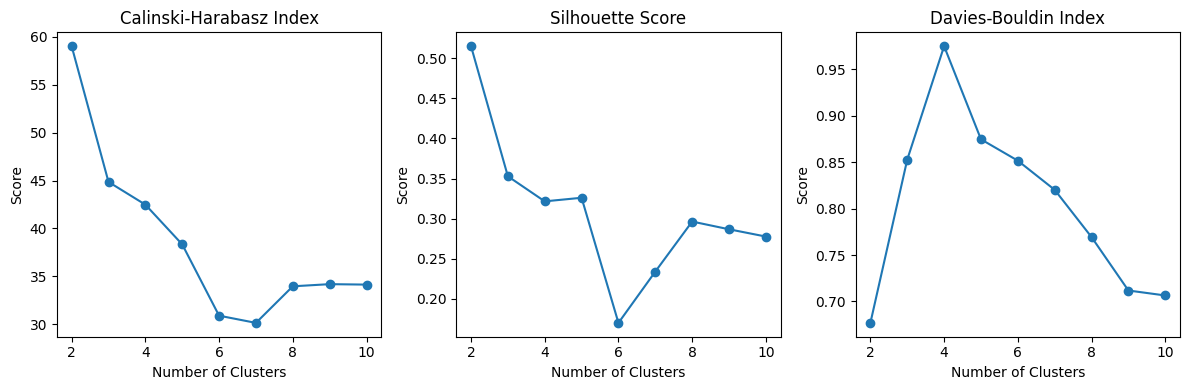

In [12]:
cluster_range = range(2, 11)

# Initialize lists to store the evaluation scores
calinski_harabasz_scores = []
silhouette_scores = []
davies_bouldin_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_clust_scaled)
    
    calinski_harabasz_scores.append(calinski_harabasz_score(df_clust_scaled, cluster_labels))
    silhouette_scores.append(silhouette_score(df_clust_scaled, cluster_labels))
    davies_bouldin_scores.append(davies_bouldin_score(df_clust_scaled, cluster_labels))

# Plotting the scores
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(cluster_range, calinski_harabasz_scores, marker='o')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.subplot(1, 3, 2)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.subplot(1, 3, 3)
plt.plot(cluster_range, davies_bouldin_scores, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

In [13]:
filename = '/mnt/d/sharegit/MasterThesis_data/DWTs/clustered_dataframe.csv'
df_scores.to_csv(filename)
df_scores

,eAir,eVib,eCar,eAll,dAir,dVib,dCar,dAll,a1,a2,...,v1,v2,v3,v4,c1,c2,c3,c4,Cluster,Cluster_3
ID,,,,,,,,,,,,,,,,,,,,,
1,47.058824,76.25,46.25,57.017544,64.705882,88.333333,80.000000,78.362573,35.294118,41.176471,...,65.0,65.0,75.0,100.0,60.0,30.0,30.0,65.0,0,0
2,66.176471,88.75,56.25,70.614035,80.392157,91.666667,78.333333,83.625731,52.941176,58.823529,...,85.0,85.0,90.0,95.0,45.0,40.0,70.0,70.0,0,0
3,50.000000,92.50,57.50,67.543860,76.470588,98.333333,88.333333,88.304094,35.294118,41.176471,...,95.0,95.0,90.0,90.0,50.0,35.0,65.0,80.0,0,0
4,69.117647,92.50,63.75,75.438596,86.274510,100.000000,83.333333,90.058480,58.823529,58.823529,...,90.0,85.0,95.0,100.0,55.0,55.0,65.0,80.0,1,2
5,61.764706,87.50,70.00,73.684211,74.509804,93.333333,83.333333,84.210526,41.176471,41.176471,...,85.0,85.0,90.0,90.0,55.0,60.0,80.0,85.0,0,0
6,76.470588,87.50,77.50,80.701754,84.313725,96.666667,90.000000,90.643275,70.588235,76.470588,...,95.0,95.0,80.0,80.0,75.0,75.0,70.0,90.0,2,1
7,63.235294,80.00,47.50,63.596491,88.235294,88.333333,76.666667,84.210526,58.823529,41.176471,...,70.0,65.0,90.0,95.0,55.0,30.0,40.0,65.0,0,0
8,48.529412,90.00,71.25,71.052632,66.666667,95.000000,91.666667,85.380117,52.941176,29.411765,...,90.0,85.0,90.0,95.0,55.0,55.0,85.0,90.0,0,0
9,75.000000,97.50,60.00,77.631579,94.117647,100.000000,86.666667,93.567251,64.705882,64.705882,...,95.0,95.0,100.0,100.0,50.0,35.0,60.0,95.0,2,1


In [14]:
df_scores[df_scores.Cluster == 0].describe()

,eAir,eVib,eCar,eAll,dAir,dVib,dCar,dAll,a1,a2,...,v1,v2,v3,v4,c1,c2,c3,c4,Cluster,Cluster_3
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,...,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.0,14.0
mean,55.462185,81.250000,57.767857,65.319549,77.450980,89.166667,82.857143,83.458647,51.680672,42.857143,...,75.000000,77.142857,83.928571,88.928571,56.071429,43.214286,56.428571,75.357143,0.0,0.0
std,8.887936,12.700318,10.414240,5.116213,6.781462,8.909565,6.648326,3.231092,11.108048,11.634705,...,22.101166,10.690450,11.631947,12.886870,8.361673,12.342413,19.751200,13.223564,0.0,0.0
min,38.235294,42.500000,37.500000,56.140351,64.705882,63.333333,68.333333,77.192982,35.294118,17.647059,...,5.000000,60.000000,50.000000,55.000000,45.000000,25.000000,15.000000,55.000000,0.0,0.0
25%,48.897059,79.062500,49.687500,61.951754,74.509804,88.333333,78.750000,81.578947,44.117647,36.764706,...,71.250000,70.000000,80.000000,90.000000,51.250000,31.250000,42.500000,65.000000,0.0,0.0
50%,55.882353,82.500000,58.125000,66.008772,78.431373,90.000000,84.166667,83.918129,52.941176,41.176471,...,77.500000,77.500000,90.000000,92.500000,55.000000,42.500000,60.000000,80.000000,0.0,0.0
75%,62.867647,89.687500,66.562500,67.872807,82.352941,94.583333,87.916667,85.233918,58.823529,52.941176,...,88.750000,85.000000,90.000000,95.000000,58.750000,53.750000,68.750000,85.000000,0.0,0.0
max,67.647059,92.500000,71.250000,73.684211,88.235294,98.333333,91.666667,88.304094,70.588235,58.823529,...,95.000000,95.000000,95.000000,100.000000,75.000000,60.000000,85.000000,90.000000,0.0,0.0


In [15]:
df_scores[df_scores.Cluster == 1].describe()

,eAir,eVib,eCar,eAll,dAir,dVib,dCar,dAll,a1,a2,...,v1,v2,v3,v4,c1,c2,c3,c4,Cluster,Cluster_3
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,...,9.000000,9.000000,9.000000,9.000000,9.0,9.000000,9.000000,9.000000,9.0,9.0
mean,69.607843,90.972222,66.527778,76.023392,85.620915,95.185185,85.370370,88.888889,67.320261,60.784314,...,88.333333,87.777778,93.333333,94.444444,65.0,56.666667,63.888889,80.555556,1.0,2.0
std,8.154806,4.497299,8.789593,2.361914,6.503186,4.203541,7.109158,1.461988,10.649785,14.105387,...,5.000000,5.651942,5.000000,6.346478,10.0,14.577380,11.395662,7.682954,0.0,0.0
min,52.941176,81.250000,57.500000,72.807018,72.549020,86.666667,76.666667,86.549708,52.941176,35.294118,...,80.000000,80.000000,85.000000,80.000000,55.0,30.000000,45.000000,70.000000,1.0,2.0
25%,66.176471,90.000000,62.500000,75.000000,84.313725,95.000000,81.666667,88.304094,58.823529,52.941176,...,85.000000,85.000000,95.000000,95.000000,55.0,50.000000,60.000000,75.000000,1.0,2.0
50%,69.117647,92.500000,63.750000,75.438596,86.274510,96.666667,83.333333,89.473684,64.705882,64.705882,...,90.000000,90.000000,95.000000,95.000000,65.0,55.000000,65.000000,80.000000,1.0,2.0
75%,76.470588,95.000000,63.750000,78.508772,90.196078,96.666667,91.666667,90.058480,70.588235,70.588235,...,90.000000,90.000000,95.000000,100.000000,65.0,65.000000,65.000000,80.000000,1.0,2.0
max,77.941176,95.000000,85.000000,79.385965,92.156863,100.000000,96.666667,90.058480,88.235294,82.352941,...,95.000000,95.000000,100.000000,100.000000,85.0,80.000000,85.000000,95.000000,1.0,2.0


In [16]:
df_scores[df_scores.Cluster == 2].describe()

,eAir,eVib,eCar,eAll,dAir,dVib,dCar,dAll,a1,a2,...,v1,v2,v3,v4,c1,c2,c3,c4,Cluster,Cluster_3
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,...,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.0,11.0
mean,82.352941,92.045455,70.000000,81.419458,93.226381,96.666667,89.545455,93.141946,80.748663,74.866310,...,90.454545,90.000000,93.636364,94.090909,69.545455,57.272727,65.454545,87.727273,2.0,1.0
std,6.991097,5.896840,10.839742,2.844275,4.751708,2.687419,4.287638,1.813637,11.189129,9.874965,...,7.567875,7.416198,6.741999,7.006490,14.908814,19.282588,13.125271,10.574412,0.0,0.0
min,73.529412,82.500000,52.500000,77.631579,84.313725,93.333333,80.000000,90.058480,64.705882,64.705882,...,75.000000,75.000000,80.000000,80.000000,45.000000,30.000000,50.000000,70.000000,2.0,1.0
25%,77.205882,88.750000,63.125000,79.385965,89.215686,94.166667,88.333333,92.397661,70.588235,67.647059,...,90.000000,87.500000,90.000000,90.000000,60.000000,40.000000,55.000000,80.000000,2.0,1.0
50%,80.882353,92.500000,71.250000,80.701754,94.117647,96.666667,90.000000,93.567251,82.352941,70.588235,...,90.000000,90.000000,95.000000,95.000000,75.000000,65.000000,60.000000,90.000000,2.0,1.0
75%,88.970588,96.250000,76.250000,83.552632,97.058824,99.166667,92.500000,93.859649,88.235294,79.411765,...,95.000000,95.000000,100.000000,100.000000,80.000000,75.000000,75.000000,95.000000,2.0,1.0
max,94.117647,100.000000,87.500000,86.403509,98.039216,100.000000,95.000000,96.491228,100.000000,94.117647,...,100.000000,100.000000,100.000000,100.000000,95.000000,80.000000,90.000000,100.000000,2.0,1.0
